In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import copy, math

%matplotlib inline

In [2]:
X_train, y_train = load_data("data/ex2data2.txt")
print(X_train.shape)
print(y_train.shape)

(118, 2)
(118,)


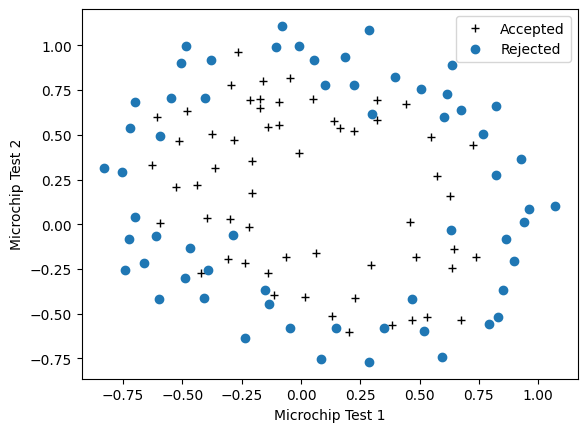

In [7]:
pos = y_train == 1
neg = y_train == 0

plt.plot(X_train[pos, 0], X_train[pos, 1], 'k+', label="Accepted")
plt.plot(X_train[neg, 0], X_train[neg, 1], 'o', label="Rejected")

plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc="upper right")
plt.show()

In [9]:
# Since no straight line can fit this data we need to map features
print(f"original shape of data: {X_train.shape}")
mapped_X = map_feature(X_train[:,0], X_train[:, 1])
print(f"shape after feature mapping: {mapped_X.shape}")
print(mapped_X[0])

original shape of data: (118, 2)
shape after feature mapping: (118, 27)
[5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


In [10]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    g = 1 / (1 + np.exp(-z))
    return g

In [20]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value
      w : (array_like Shape (n,)) Values of parameters of the model
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost
    """
    m = X.shape[0]
    cost = 0.

    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_i)
        cost += -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)
    cost /= m

    reg_cost = sum(np.square(w))

    total_cost = cost + (lambda_ / (2 * m)) * reg_cost

    return total_cost

In [21]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)

Regularized cost : 0.6618252552483948


In [22]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the gradient for linear regression

    Args:
      X : (ndarray Shape (m,n))   variable such as house size
      y : (ndarray Shape (m,))    actual value
      w : (ndarray Shape (n,))    values of parameters of the model
      b : (scalar)                value of parameter of the model
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b.
      dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w.

    """
    m,n = X.shape
    dj_dw = np.zeros((n, ))
    dj_db = 0.

    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_i)
        err_i = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] += err_i * X[i, j]
        dj_db += err_i
    dj_dw /= m
    dj_db /= m

    for j in range(n):
        dj_dw[j] += (lambda_ / m) * w[j]

    return dj_db, dj_dw

In [27]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5

lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)
print(f"dj_dw shape: {dj_dw.shape}", )
print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )

dj_dw shape: (27,)
dj_db: 0.07138288792343662
First few elements of regularized dj_dw:
 [-0.010386028450548701, 0.011409852883280122, 0.0536273463274574, 0.003140278267313462]


In [29]:
def gradient_descent(X, y, w_in, b_in, num_iters, alpha, cost_function, gradient_function, lambda_ = 1):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant

    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    w = copy.deepcopy(w_in)
    b = b_in
    J_history = []

    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b, lambda_)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 10000:
            J_history.append(cost_function(X, y, w, b, lambda_))

        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}")
    return w, b, J_history

In [30]:
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

lambda_ = 0.01
iterations = 10000
alpha = 0.01

w, b, J_history = gradient_descent(X_mapped, y_train, initial_w, initial_b, iterations, alpha,
                                    compute_cost_reg, compute_gradient_reg, lambda_)
print(f"w: {w}\nb:{b}")

Iteration    0: Cost     0.72
Iteration 1000: Cost     0.59
Iteration 2000: Cost     0.56
Iteration 3000: Cost     0.53
Iteration 4000: Cost     0.51
Iteration 5000: Cost     0.50
Iteration 6000: Cost     0.48
Iteration 7000: Cost     0.47
Iteration 8000: Cost     0.46
Iteration 9000: Cost     0.45
w: [ 0.91430359  1.4923378  -2.59208306 -1.0206783  -1.70874963 -0.09508199
 -0.70729902 -0.45522579 -0.2625241  -1.50258859 -0.14183125 -0.44103606
 -0.5216627  -0.85782008 -0.62213889 -0.0730526  -0.11749311 -0.22665893
 -0.62206091 -0.81773062 -0.81412362  0.47440112 -0.48661532  0.20171914
  0.03665575  0.27726316 -1.43466503]
b:1.43411872285427


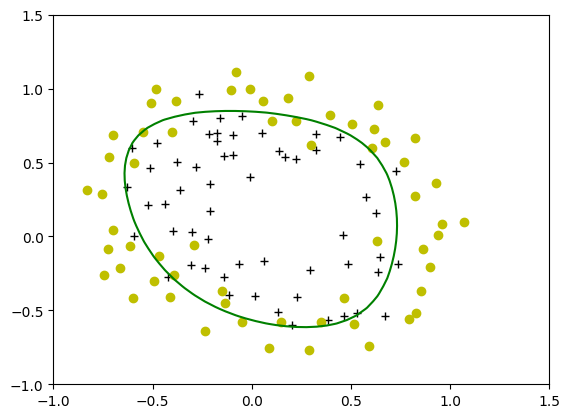

In [31]:
plot_decision_boundary(w, b, X_mapped, y_train)

In [32]:
def predict(X, w, b):
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w

    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    m, n = X.shape
    p = np.zeros(m)

    for i in range(m):
        z_wb = np.dot(X[i], w)
        for j in range(n):
            z_wb += 0

        z_wb += b
        f_wb = sigmoid(z_wb)
        p[i] = 1 if f_wb > 0.5 else 0

    return p

In [33]:
p = predict(X_mapped, w, b)
print(f"Train Accuracy: {np.mean(p == y_train) * 100}")

Train Accuracy: 82.20338983050848
